### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = 'sample2B.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

In [3]:
print(centroids)

[[   0    9]
 [   0  120]
 [   0 1244]
 [   0   25]
 [   0   63]
 [   0   11]
 [   0   70]
 [   0   68]
 [   0    9]
 [   0  459]
 [   0   12]
 [   0    6]
 [   0   10]
 [   0   10]
 [   0  227]
 [   0   67]
 [   0   81]
 [   0    2]
 [   0   47]
 [   0    5]
 [   0   32]
 [   0   75]
 [   0  461]
 [   0  211]
 [   0   60]
 [   0   17]
 [   0   79]
 [   0   67]
 [   0   21]
 [   0    8]
 [   0  120]
 [   0   61]
 [   0    1]
 [   0   61]
 [   0   58]
 [   0    2]
 [   0   62]
 [   0   10]
 [   0   28]
 [   0  148]
 [   0   64]
 [   0   48]
 [   0   15]
 [   0   57]
 [   0   60]
 [   0   60]
 [   0   79]
 [   0   63]
 [   0   71]
 [   0   15]
 [   0   26]
 [   0  145]
 [   0   17]
 [   0   62]
 [   0   56]
 [   0   63]
 [   0   24]
 [   0   42]
 [   0   68]
 [   0    9]
 [   0   38]
 [   0  123]
 [   0   34]
 [   0   86]
 [   0   20]
 [   0   21]
 [   0   47]
 [   0   40]
 [   0   18]
 [   0   42]
 [   0   38]
 [   0   33]
 [   0   27]
 [   0   28]
 [   0   21]
 [   0   22]
 [   0    6]

 ## Extract Droplet Centroids

In [53]:
import cv2

# Load image
image = cv2.imread('sample2B.png')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply histogram equalization
equalized_image = cv2.equalizeHist(gray_image)
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
adaptive_equalized_image = clahe.apply(gray_image)
# Apply Otsu’s thresholding
ret, thresholded_image = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Apply Canny edge detection
edges = cv2.Canny(equalized_image, threshold1=100, threshold2=200)
# Define kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Apply morphological opening (removes small noise)
opened_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel)

# Apply morphological closing (fills small holes)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)
# Set up SimpleBlobDetector
params = cv2.SimpleBlobDetector_Params()

# Adjust the parameters (e.g., area, circularity, convexity, inertia)
params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.minCircularity = 0.5
params.filterByConvexity = True
params.minConvexity = 0.5
params.filterByInertia = True
params.minInertiaRatio = 0.5

# Create a blob detector with the given parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs (droplets)
keypoints = detector.detect(closed_image)

# Draw keypoints on the image to visualize the detected centroids
output_image = cv2.drawKeypoints(closed_image, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
centroids = [kp.pt for kp in keypoints]
print("Droplet centroids:", centroids)



[ WARN:0@2859.960] global loadsave.cpp:268 findDecoder imread_('sample2B.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


[[ 103  754]
 [ 161  752]
 [ 920  749]
 [1002  740]
 [  89  740]
 [ 564  746]
 [ 182  734]
 [  21  743]
 [ 186  724]
 [1002  721]
 [ 690  736]
 [1003  710]
 [  83  711]
 [  86  697]
 [ 742  681]
 [ 379  714]
 [ 694  667]
 [ 174  675]
 [ 268  701]
 [ 109  667]
 [ 944  675]
 [ 483  685]
 [ 836  688]
 [ 777  636]
 [1002  615]
 [ 777  613]
 [  24  654]
 [ 596  655]
 [ 673  605]
 [ 989  602]
 [ 675  595]
 [ 410  616]
 [ 984  588]
 [ 211  610]
 [ 722  571]
 [ 143  548]
 [ 314  585]
 [ 900  578]
 [ 104  575]
 [ 503  568]
 [ 183  526]
 [ 809  554]
 [ 990  547]
 [  15  541]
 [ 181  505]
 [ 410  524]
 [ 622  529]
 [ 895  475]
 [ 730  487]
 [ 434  453]
 [ 389  442]
 [ 817  459]
 [ 214  479]
 [ 319  467]
 [ 682  425]
 [   5  441]
 [ 678  415]
 [ 975  447]
 [  87  454]
 [ 535  453]
 [  30  382]
 [   5  377]
 [ 878  403]
 [  51  375]
 [ 375  397]
 [ 916  364]
 [ 383  361]
 [ 477  356]
 [  69  354]
 [ 635  392]
 [ 446  339]
 [ 253  369]
 [ 755  370]
 [ 873  333]
 [ 148  344]
 [ 980  329]
 [  44  301]

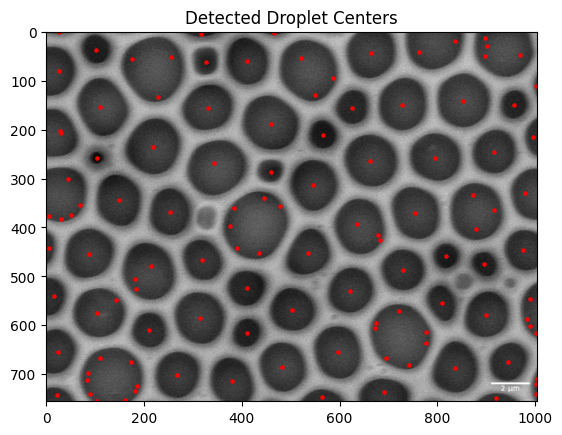

In [18]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample4B.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Contrast Enhancement (Histogram Equalization)
equalized_image = cv2.equalizeHist(image)

# Step 2: Apply Manual Thresholding (with dynamic range)
# Experiment with threshold values based on your image contrast
_, thresh = cv2.threshold(equalized_image, 100, 255, cv2.THRESH_BINARY_INV)

# Step 3: Apply Morphological Operations (Opening followed by Closing)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # More elliptical kernel for smoother operation
opened_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

# Step 4: Find Contours instead of using Blob Detector
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Identify Droplet Centroids using Contour Moments
centroids = []
for contour in contours:
    # Calculate the centroid of each contour using moments
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Prevent division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append([cx, cy])
# centroids.append([267,98])
# Convert centroids to a numpy array for easier plotting
centroids = np.array(centroids)
print(centroids)
# centroids = np.all(np.isin(centroids,rows_to_remove),axis=1)
# centroids = centroids[~centroids]
# print(centroids.shape)
# Plot Results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()


[[ 922  748]
 [ 565  745]
 [  24  742]
 [ 691  735]
 [ 999  727]
 [  27  654]
 [ 411  616]
 [ 211  611]
 [ 809  554]
 [ 989  570]
 [  18  541]
 [ 853  511]
 [ 410  525]
 [ 896  478]
 [ 818  461]
 [   8  442]
 [ 973  448]
 [ 324  382]
 [ 980  332]
 [ 458  285]
 [ 105  259]
 [ 565  212]
 [ 993  216]
 [ 956  150]
 [ 626  155]
 [1000  110]
 [ 326   60]
 [ 102   37]
 [ 464    3]
 [ 320    6]
 [  24    2]]


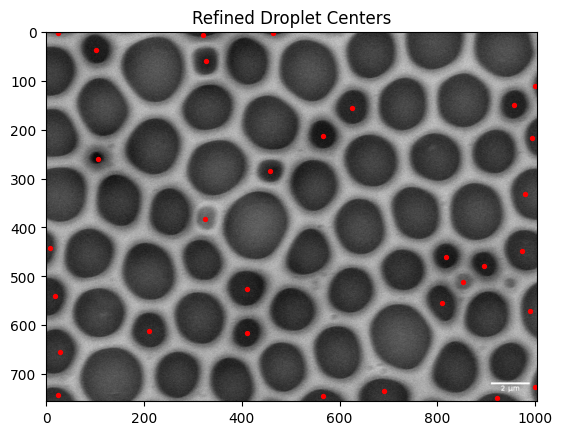

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample4B.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Apply Otsu’s Thresholding for better segmentation
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Morphological Operations to refine segmentation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 4: Find Contours and Filter by Area
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

centroids = []
min_area = 100  # Adjust to remove small noise
max_area = 5000  # Adjust to exclude large non-droplet objects

for contour in contours:
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        # Use Convex Hull to refine the droplet shape
        hull = cv2.convexHull(contour)
        M = cv2.moments(hull)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append([cx, cy])

# Convert to numpy array
centroids = np.array(centroids)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Refined Droplet Centers')
plt.show()


[[509 651]
 [670 644]
 [192 639]
 [344 636]
 [707 582]
 [ 53 631]
 [767 557]
 [717 544]
 [820 606]
 [587 550]
 [269 521]
 [128 513]
 [436 519]
 [ 18 499]
 [ 24 435]
 [856 468]
 [837 412]
 [731 465]
 [735 387]
 [722 361]
 [578 416]
 [ 58 390]
 [192 390]
 [326 392]
 [454 371]
 [817 321]
 [ 21 277]
 [673 293]
 [804 215]
 [535 256]
 [260 252]
 [389 250]
 [131 254]
 [798 183]
 [755 197]
 [805 135]
 [848 163]
 [324 137]
 [ 45 124]
 [462 117]
 [629 123]
 [764  88]
 [194  97]
 [839  26]
 [696  11]
 [533  19]
 [347  26]
 [206   2]
 [ 62  15]]


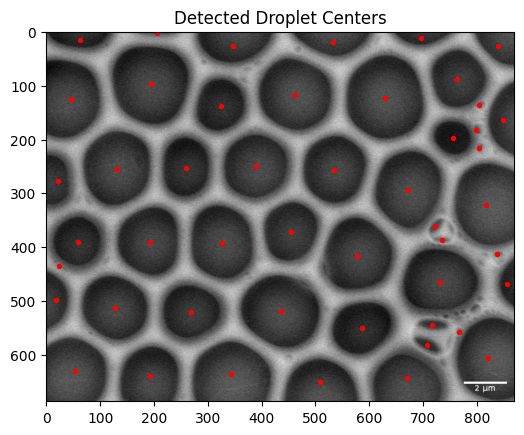

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "sample6B.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Use adaptive thresholding to segment pores
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours of the pores
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Compute the centers of the detected pores
centers = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centers.append((cx, cy))
centroids = np.array(centers)
print(centroids)
# Step 5: Plot the results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=8)
plt.title('Detected Droplet Centers')
plt.show()


## Perform Voronoi Tessellation

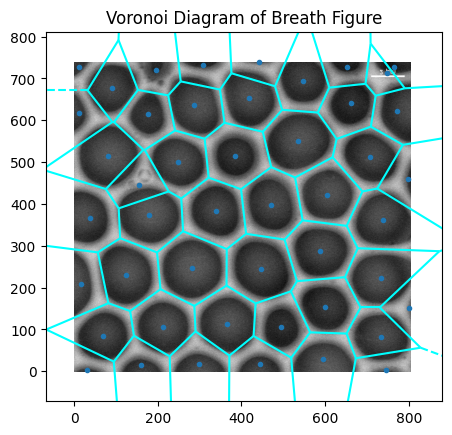

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

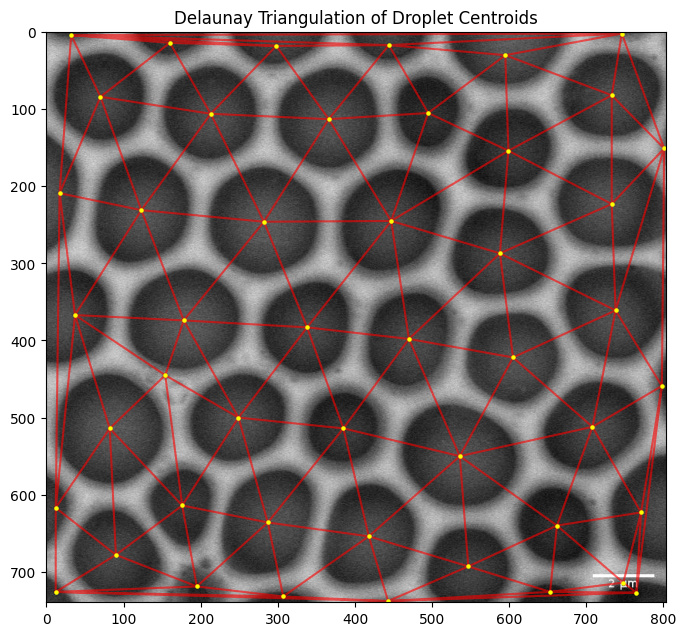

In [4]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.50


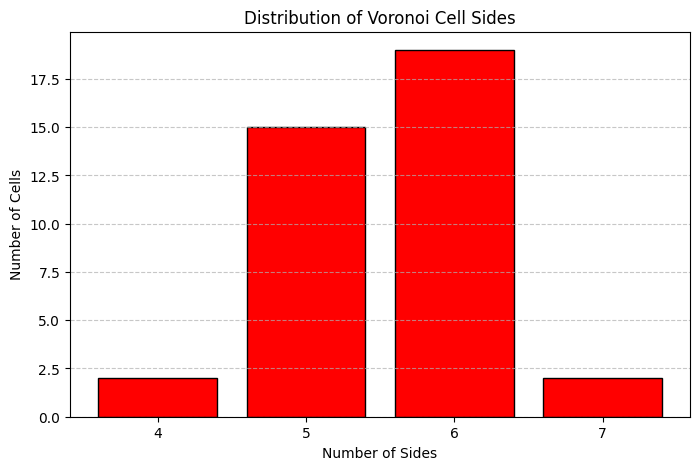

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

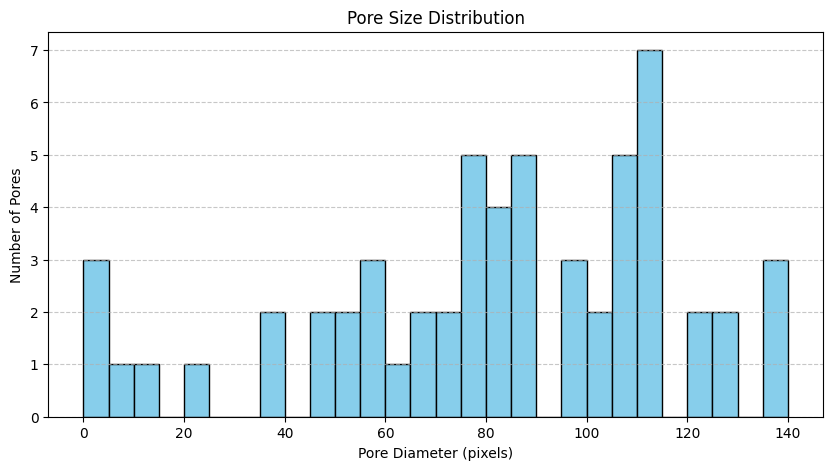

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('sample2A.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()